In [25]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [26]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [27]:
len(words)

32033

In [28]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
print(f'{itos=}')
print(f'{vocab_size=}')

itos={1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
vocab_size=27


In [29]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1]) # 80%
Xdev, Ydev = build_dataset(words[n1:n2]) # 10%
Xte, Yte = build_dataset(words[n2:]) # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
# MLP
n_embed = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embed), generator=g)
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01 # W2 scaled down significantly
b2 = torch.randn(vocab_size, generator=g) * 0 # b2 reduced to 0
parameters = [C, W1, b1, W2, b2]

n_parameters = sum(p.nelement() for p in parameters)
print(f'{n_parameters=}')
for p in parameters:
    p.requires_grad = True

n_parameters=11897


In [46]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,),generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # cancatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.1857
  10000/ 200000: 1.8700
  20000/ 200000: 1.9252
  30000/ 200000: 2.0570
  40000/ 200000: 2.2073
  50000/ 200000: 2.1325
  60000/ 200000: 2.1533
  70000/ 200000: 2.8029
  80000/ 200000: 2.6544
  90000/ 200000: 2.2931
 100000/ 200000: 2.2813
 110000/ 200000: 1.8629
 120000/ 200000: 2.1695
 130000/ 200000: 1.9693
 140000/ 200000: 1.8043
 150000/ 200000: 2.4483
 160000/ 200000: 2.2238
 170000/ 200000: 1.7788
 180000/ 200000: 1.9207
 190000/ 200000: 2.1602


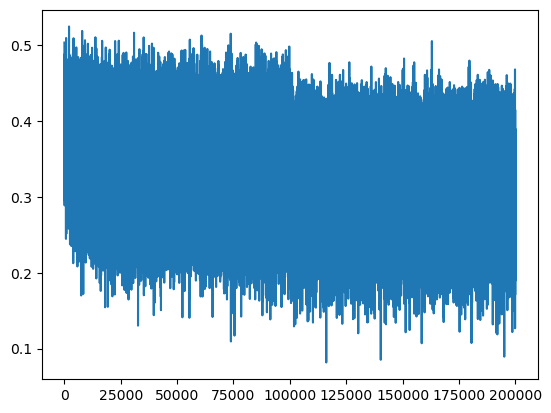

In [47]:
plt.plot(lossi)

In [48]:
@torch.no_grad() # this decorator disables gradient tracking
# this prevents torch from keeping track of computational graph, because we aren't going to do backward pass
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embed)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embed)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0695769786834717
val 2.131199836730957


In [49]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carman.
amille.
khyrmyn.
reet.
khalayane.
mahnen.
deliah.
jareei.
nellara.
chaiivon.
legen.
ham.
jorn.
quintin.
lilea.
jadiquinterri.
jarysia.
kael.
dustine.
deciia.


In [ ]:
# currently the initial loss of the model is very high
# even if we assign equal probabilities to each character
# there are 27 total possibilties, so prob for every character given a context is 1/27
# by this the loss would 3.2958

-torch.tensor(1/27.0).log()

tensor(3.2958)

In [24]:
# 4-dimensional example of the issue
# you can see if logits are assigned uniformly, there's very low loss, for any particular item, and average also
logits = torch.tensor([0.0, 0.0, 0.0, 0.0])
probs = torch.softmax(logits, dim=0)
loss_item = -probs[2].log()
loss = -probs.log().mean()
logits, probs, loss_item, loss

(tensor([0., 0., 0., 0.]),
 tensor([0.2500, 0.2500, 0.2500, 0.2500]),
 tensor(1.3863),
 tensor(1.3863))

In [ ]:
# logit for index 2 is low, so it's probability is low and loss will be high
logits = torch.tensor([0.0, 5.0, 0.0, 0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, loss

(tensor([0., 5., 0., 0.]),
 tensor([0.0066, 0.9802, 0.0066, 0.0066]),
 tensor(5.0200))

In [ ]:
# prob for index 1 is high, as logit was high
logits = torch.tensor([0.0, 5.0, 0.0, 0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[1].log()
logits, probs, loss

(tensor([0., 5., 0., 0.]),
 tensor([0.0066, 0.9802, 0.0066, 0.0066]),
 tensor(0.0200))

In [19]:
# on random initialisation if there are extreme values, then average loss will be high
logits = torch.randn(4)
probs = torch.softmax(logits, dim=0)
loss = -probs.log().mean()
logits, probs, loss

(tensor([0.1228, 1.1479, 0.4853, 1.2244]),
 tensor([0.1215, 0.3386, 0.1745, 0.3655]),
 tensor(1.4859))

In [20]:
logits = torch.randn(4) * 10
probs = torch.softmax(logits, dim=0)
loss = -probs.log().mean()
logits, probs, loss

(tensor([ -3.1819,  14.8684,   5.7819, -11.4434]),
 tensor([1.4481e-08, 9.9989e-01, 1.1317e-04, 3.7398e-12]),
 tensor(13.3623))

In [23]:
logits = torch.randn(4) * 30
probs = torch.softmax(logits, dim=0)
loss = -probs.log().mean()
logits, probs, loss

(tensor([ -3.5484, -45.0302,  38.0217, -10.8688]),
 tensor([8.8376e-19, 8.5318e-37, 1.0000e+00, 5.8495e-22]),
 tensor(43.3781))

In [ ]:
# so in this lecture
# we wanted logits to take less extreme values
# which results in uniform probabilties and lower loss
# so we set b2 to 0 and W2 to very low number, by multiplying by 0.01
# this way loss curve no longer has hockey stick appearence
# so there are no easy gains, which comes from initial runs which are spent in just squashing down the weights
# and model is spending more time optimizing weights on given data